# Import

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import copy
import torch
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.butterfly_module import GraceLitModule
from src.models.components.butterfly_net import ButterflyNet
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Helper Functions

In [2]:
torch.set_default_device('cuda')
torch.set_default_dtype(d=torch.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

def min_max_scaler(arr, min_val, max_val):
    scaled_arr = 2 * (arr - min_val) / (max_val - min_val) - 1
    return scaled_arr

def preprocess_csv(data_dir, val_size=0.3):
        # Read CSV
        df = pd.read_csv(data_dir)

        # Add Cmd of Current Time Step
        df['cmd_lnt_t'] = np.array(len(df)*[-13])
        df['cmd_lnp_t'] = np.array(len(df)*[-40])
        df['cmd_unt_t'] = np.array(len(df)*[44])
        df['cmd_lep_t'] = np.array(len(df)*[-18])
        df['cmd_rep_t'] = np.array(len(df)*[-18])
        df['cmd_et_t'] = np.array(len(df)*[22])
        
        # Reorganizing DataFrame
        data_df = pd.DataFrame({
            'l_rvec_0': df['l_rvec_0'].values,
            'l_rvec_1': df['l_rvec_1'].values,
            'l_rvec_2': df['l_rvec_2'].values,
            'l_tvec_0': df['l_tvec_0'].values,
            'l_tvec_1': df['l_tvec_1'].values,
            'l_tvec_2': df['l_tvec_2'].values,
            'r_rvec_0': df['r_rvec_0'].values,
            'r_rvec_1': df['r_rvec_1'].values,
            'r_rvec_2': df['r_rvec_2'].values,
            'r_tvec_0': df['r_tvec_0'].values,
            'r_tvec_1': df['r_tvec_1'].values,
            'r_tvec_2': df['r_tvec_2'].values,
            'cmd_lnt_t': df['cmd_lnt_t'].values,
            'cmd_lnt_tplus1': df['cmd_theta_lower_neck_tilt'].values,
            'cmd_lnp_t': df['cmd_lnp_t'].values,
            'cmd_lnp_tplus1': df['cmd_theta_lower_neck_pan'].values,
            'cmd_unt_t': df['cmd_unt_t'].values,
            'cmd_unt_tplus1': df['cmd_theta_upper_neck_tilt'].values,
            'cmd_et_t': df['cmd_et_t'].values,
            'cmd_et_tplus1': df['cmd_theta_eyes_tilt'].values,
            'cmd_lep_t': df['cmd_lep_t'].values,
            'cmd_lep_tplus1': df['cmd_theta_left_eye_pan'].values,
            'cmd_rep_t': df['cmd_rep_t'].values,
            'cmd_rep_tplus1': df['cmd_theta_right_eye_pan'].values,
        })
        
        # Minmax Feature Scaler
        feature_ranges = {
            'l_tvec_0': (-1.5, 1.5),  
            'l_tvec_1': (-1.5, 1.5),  
            'l_tvec_2': (-1.5, 1.5),
            'r_tvec_0': (-1.5, 1.5),
            'r_tvec_1': (-1.5, 1.5),  
            'r_tvec_2': (-1.5, 1.5),
            'cmd_lnt_t': (-44, 44),
            'cmd_lnp_t': (-44, 44),
            'cmd_unt_t': (-44, 44),
            'cmd_et_t': (-44, 44),
            'cmd_lep_t': (-44, 44),
            'cmd_rep_t': (-44, 44),
            'cmd_lnt_tplus1': (-44, 44),  # Original Range: (-13, 31)   
            'cmd_lnp_tplus1': (-44, 44),
            'cmd_unt_tplus1': (-44, 44),  # Original Range: (-13, 44)
            'cmd_et_tplus1': (-44, 44),  # Original Range: (-31, 22)
            'cmd_lep_tplus1': (-44, 44),
            'cmd_rep_tplus1': (-44, 44),
        }

        # Separation of Training and Validation Set
        train_df, temp_df = train_test_split(data_df, test_size=val_size, random_state=42)
        val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42)

        # Training Set
        X_train = torch.tensor(train_df.values, dtype=torch.float32)
        y_train = torch.tensor(train_df.values, dtype=torch.float32)
        train_dataset = TensorDataset(X_train, y_train)

        # Validation Set
        X_val = torch.tensor(val_df.values, dtype=torch.float32)
        y_val = torch.tensor(val_df.values, dtype=torch.float32)
        val_dataset = TensorDataset(X_val, y_val)
        
        # Test Set
        X_test = torch.tensor(test_df.values, dtype=torch.float32)
        y_test = torch.tensor(test_df.values, dtype=torch.float32)
        test_dataset = TensorDataset(X_test, y_test)
        
        # Create the scaled DataFrame
        scaled_test_df = test_df.copy()
        for col in test_df[feature_ranges.keys()].columns:
            col_min, col_max = feature_ranges[col]
            scaled_test_df[col] = 2 * (test_df[col] - col_min) / (col_max - col_min) - 1

        return test_df, scaled_test_df

# Error Histogram

In [9]:
csv_fn = '/home/jaynieles/dev/grace_dl/logs/fk/runs/2024-10-21_02-20-13/tensorboard/version_0/delta_output_analysis.csv'
csv_df = pd.read_csv(csv_fn)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   3.,   2.,  26.,  33., 104., 223., 304., 416., 482., 441.,
        407., 393., 290., 232., 138.,  51.,  29.,   5.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.2 , -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12,
        -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03,
        -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,
         0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,
         0.16,  0.17,  0.18,  0.19,  0.2 ]),
 <BarContainer object of 40 artists>)

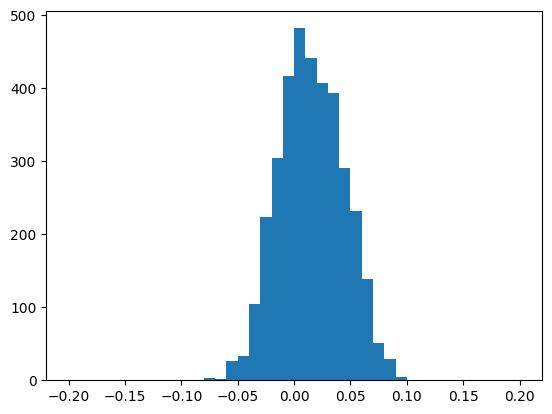

In [26]:
plt.hist(csv_df['delta_r_tvec_0'], bins=40, range=(-0.2,0.2))

# Load Dataset

In [3]:
test_df, scaled_test_df = preprocess_csv("/home/jaynieles/dev/grace_dl/data/thesis/241003_075m_grace_dataset.csv")
test_df

,l_rvec_0,l_rvec_1,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,...,cmd_lnp_t,cmd_lnp_tplus1,cmd_unt_t,cmd_unt_tplus1,cmd_et_t,cmd_et_tplus1,cmd_lep_t,cmd_lep_tplus1,cmd_rep_t,cmd_rep_tplus1
65891,-0.366268,0.217861,0.173883,-0.054835,0.220838,-0.093170,-0.407066,-0.072069,0.136426,-0.099139,...,-40,10,44,40,22,10,-18,-10,-18,-10
21499,0.026404,0.000122,0.114632,-0.050081,0.187353,-0.036475,-0.017541,-0.289378,0.142233,-0.114080,...,-40,20,44,0,22,15,-18,-8,-18,-8
51072,-0.369755,-0.252033,0.155178,-0.067862,0.226244,-0.096876,-0.418010,-0.573613,0.123270,-0.098688,...,-40,25,44,30,22,-5,-18,0,-18,0
52443,-0.360437,-0.121982,-0.019978,0.009035,0.235348,-0.086556,-0.388981,-0.458705,-0.050414,-0.032189,...,-40,-5,44,30,22,5,-18,12,-18,12
37200,-0.241590,0.731112,-0.037504,0.038403,0.242648,-0.065029,-0.263190,0.405582,-0.058404,-0.006697,...,-40,-30,44,20,22,-10,-18,-6,-18,-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58014,0.036647,-0.020800,0.110023,-0.046110,0.210137,-0.026678,-0.003120,-0.328611,0.142655,-0.108846,...,-40,15,44,30,22,-30,-18,-4,-18,-4
15880,0.136810,-0.137934,0.040401,-0.012253,0.206113,0.012615,0.103648,-0.472589,0.095978,-0.083539,...,-40,-5,44,0,22,-25,-18,12,-18,12
6802,0.126747,-0.098022,0.060217,-0.044916,0.187601,-0.013007,0.095800,-0.406286,0.107885,-0.110229,...,-40,20,44,-10,22,0,-18,-4,-18,-4
8439,0.281814,0.064421,0.017389,0.000781,0.179683,0.014780,0.246081,-0.247088,0.089158,-0.075841,...,-40,-5,44,-10,22,-10,-18,4,-18,4


In [4]:
# Test Set

X_test = torch.tensor(scaled_test_df.values, dtype=torch.float32, device=device)
y_test = torch.tensor(scaled_test_df.values, dtype=torch.float32, device=device)
test_dataset = TensorDataset(X_test, y_test)

test_dataloader = DataLoader(
            dataset=test_dataset
        )

# Load ANN Model

In [5]:
ckpt_path = '/home/jaynieles/dev/grace_dl/logs/initial_butterfly/runs/2024-10-20_23-05-46/checkpoints/epoch_137.ckpt'

In [6]:
model = GraceLitModule.load_from_checkpoint(ckpt_path)

/home/jaynieles/dev/aec/venv/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [7]:
model.eval()
# Output of DNN
with torch.no_grad():
    output = model(X_test)
    output1,output2,latent1,latent2 = output

In [8]:
idx = 100
print('==rvec tvec==')
print('true:',y_test[idx][:12].cpu().numpy())
print('input:',X_test[idx][:12].cpu().numpy())
print('output:',output1[idx].cpu().numpy())
print('==motor cmds==')
print('true:',y_test[idx][12:].cpu().numpy())
print('input:',X_test[idx][12:].cpu().numpy())
print('output:',output2[idx].cpu().numpy())
print('==latent==')
print('latent1:', latent1[idx].cpu().numpy())
print('latent2:', latent2[idx].cpu().numpy())

==rvec tvec==
true: [-0.10687082  0.48990512 -0.07543367  0.04016363  0.16218664 -0.01810537
 -0.12501204  0.15362921 -0.0713404   0.00229677  0.16044964 -0.0234148 ]
input: [-0.10687082  0.48990512 -0.07543367  0.04016363  0.16218664 -0.01810537
 -0.12501204  0.15362921 -0.0713404   0.00229677  0.16044964 -0.0234148 ]
output: [-0.04788117  0.4085572  -0.04783196  0.01801274  0.14338113 -0.02134002
 -0.06770657  0.09073803 -0.03424694 -0.02067075  0.14152537 -0.02857368]
==motor cmds==
true: [-0.29545453  0.         -0.90909094 -0.79545456  1.          0.6818182
  0.5        -0.6818182  -0.4090909   0.13636364 -0.4090909   0.13636364]
input: [-0.29545453  0.         -0.90909094 -0.79545456  1.          0.6818182
  0.5        -0.6818182  -0.4090909   0.13636364 -0.4090909   0.13636364]
output: [-0.29590937  0.30235583 -0.90986556 -0.5177932   1.0000789   0.64031243
  0.50009906 -0.5116689  -0.40923834  0.00771298 -0.40937626  0.00771294]
==latent==
latent1: [0.01946539 0.01434331 0.0806